# Solve fluid diffusion equation in a the 2D domain with one fracture and an imposed flux on L_left (2 materials)

In [1]:
import numpy as np
from mpi4py import MPI
import pyvista
import ufl

from ufl import Measure

from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, Constant, Function
from dolfinx.mesh import locate_entities

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Read the mesh

In [2]:
# Read the mesh
with XDMFFile(MPI.COMM_WORLD, "mesh_2D/1crack2D_mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    cell_tags = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)

with XDMFFile(MPI.COMM_WORLD, "mesh_2D/1crack2D_facet_mesh.xdmf", "r") as xdmf:
    facet_tags = xdmf.read_meshtags(mesh, name="Grid")

## Plot the mesh

In [3]:
topology, cell_types, geometry = plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

pyvista.set_jupyter_backend("pythreejs")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

## Define temporal parameters

In [4]:
t = 0 # Start time
T = 1000.0 # Final time 1000
num_steps = 50     
dt = T / num_steps # time step size

## Finite element function space

In [5]:
V = FunctionSpace(mesh, ("CG", 1))  # Lagrange element and linear elements (degree 1)

## Set initial conditions

In [6]:
p_n = Function(V)
p_n.name = "p_n"

## Boundary conditions

In [7]:
# DIRICHLET: p=0 on all Dirichlet BC (side 4)
boundary_dofs = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 4])
bc = fem.dirichletbc(ScalarType(0), boundary_dofs, V)

# NEUMANN: dp/dn=-10 on the left side (side 3)
# here we only want to integrate on the left side so we can create a custom integration measure ds which only integrates over facets marked with value i
ds = Measure("ds", domain=mesh, subdomain_data=facet_tags)
g = -4

## Time-dependent output

In [8]:
p_h = p_n.copy()
p_h.name = "p_h"

## Trial and test functions

In [9]:
p, r = ufl.TrialFunction(V), ufl.TestFunction(V)

## Source term

In [10]:
# here f=0 as there is no source term
f = fem.Constant(mesh, ScalarType(0))

## Material parameters

In [11]:
# this link could help later when I will have physical volumes: https://fenicsproject.discourse.group/t/subdomain-for-different-materials-based-on-physical-volume/3541

# constant storage coefficient over the domain
S = 1 

# varying permeability over the domain: 
Q = FunctionSpace(mesh, ("DG", 0))
kappa = Function(Q)
# very low permeability in the rock
rock_mask = (cell_tags.values == 5) | (cell_tags.values == 6)
kappa.x.array[rock_mask] = np.full(rock_mask.sum(), 0.000001)
# hight permeability in the fracture
fracture_mask = (cell_tags.values == 7)
kappa.x.array[fracture_mask] = np.full(fracture_mask.sum(), 1)

## Variational problem

As the test function is zero on the boundary integrals over the Dirichlet boundary, we can integrate g*v*ds over the entire boundary.

In [12]:
a = S * p * r * ufl.dx + dt * kappa * ufl.dot(ufl.grad(p), ufl.grad(r)) * ufl.dx 
L = (S * p_n + dt * f) * r * ufl.dx - dt * g * r * ds(3)

## Preparation of linear algebra structures for time dependent problems

In [13]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [14]:
# bilinear_form (a) isn't time dependant so we can assemble it once (we could do the same for the integral of the Neumann term as the flux is contant, but for now let's stay like that)
A = fem.petsc.assemble_matrix(bilinear_form, bcs=[bc])
A.assemble()
b = fem.petsc.create_vector(linear_form)

## Linear solver

In [15]:
# here matrix A is already assembled so we don't need to use petsc.LinearProblem like in tuto1
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [16]:
import pyvista
pyvista.set_jupyter_backend("ipygany")

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(V))

def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter()
    # Update point values on pyvista grid
    grid.point_data[f"u({t})"] = uh.x.array.real
    # Warp mesh by point values
    warped = grid.warp_by_scalar(f"u({t})", factor=1.5)

    # Add mesh to plotter and visualize in notebook or save as figure
    actor = p.add_mesh(warped)
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        pyvista.start_xvfb()
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)
plot_function(0, p_h)

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0)</h3>'), Dropdown(description='Colormap:', options={'Br…

In [17]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, p_h.vector)
    p_h.x.scatter_forward()

    # Update solution at previous time step (u_n)
    p_n.x.array[:] = p_h.x.array

    # Plot every 15th time step
    if i % 15 == 0:
        plot_function(t, p_h)

AppLayout(children=(VBox(children=(HTML(value='<h3>u(20.0)</h3>'), Dropdown(description='Colormap:', options={…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(320.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(620.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(920.0)</h3>'), Dropdown(description='Colormap:', options=…

## Post-processing

We can compare the obtained steady state with the one computed by hand

In [18]:
import matplotlib.pyplot as plt

In [19]:
# analytical solution for a 1D diffusion in steady state
def p_analytical(x):
    source = -g  # same flow as Neumann
    L = 10
    kappa = 1
    return source/kappa*(L-x)

In [20]:
# look for the pressures on L_middle
x_bottom = mesh.geometry.x[np.isclose(mesh.geometry.x[:,1], 5.1*np.ones(mesh.geometry.x[:,1].size))][:,0]
p_bottom = p_h.x.array[np.isclose(mesh.geometry.x[:,1], 5.1*np.ones(mesh.geometry.x[:,1].size))]
# sort these pressures according to the radial distance from point A 
index_order = np.argsort(x_bottom)
x_numerical = x_bottom[index_order]
p_numerical = p_bottom[index_order]

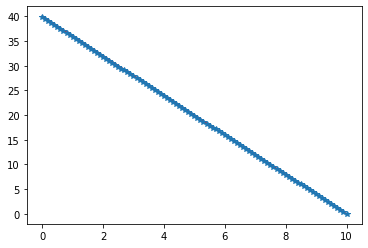

In [21]:
# plot with matplotlib

# x axis for analytical solution
x = np.arange(0., 10., 0.01)

# plot
plt.plot(x, p_analytical(x), 'r-', x_numerical, p_numerical, '*')
plt.show()